### Imports

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from IPython import embed
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from pytorch_cnn import *
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import numpy as np
import random

%matplotlib notebook

### Get data

In [27]:
# Seed for reproducibility
torch.manual_seed(0)
random.seed(0)

# Set device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# Get and transform dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=1)
# Class labels for CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Pick some images
Get same 10 images as always, where images[6] corresponds to the peacock used for the visualisation 

<IPython.core.display.Javascript object>


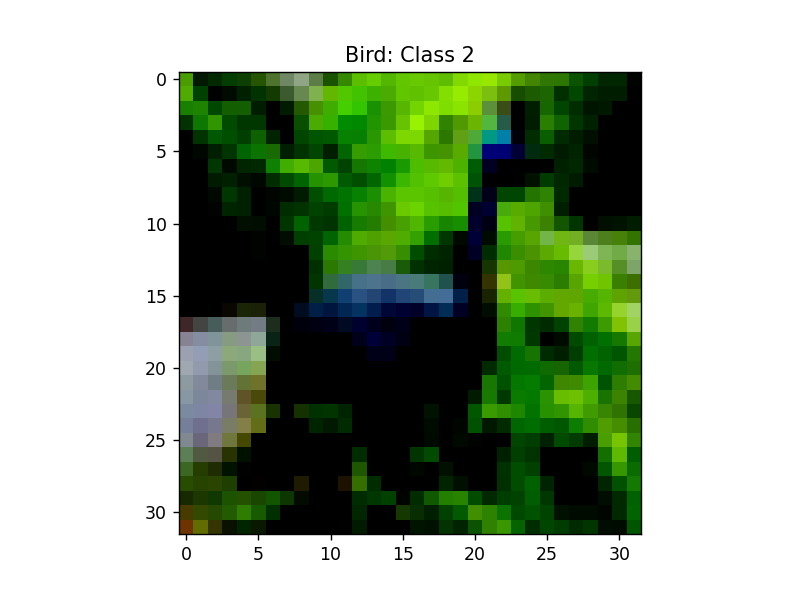

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [28]:
# Get a batch of images and labels
images, labels = next(iter(torch.utils.data.DataLoader(trainset, batch_size=10))) 
peacock = images[6].numpy().transpose((1, 2, 0))
fig1 = plt.figure()
plt.imshow(peacock)
plt.title(f'Bird: Class {str(labels[6].item())}')
plt.savefig('peacock.pdf')

### CNN model

In [29]:
# define the CNN model
class CNN(nn.Module):
    def __init__(self, kernel_size, pooling_size, padding_size, stride, image_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=stride, padding=padding_size)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pooling_size)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding_size)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pooling_size)

        # Calculate the input of the Linear layer   
        t = time.time()  
        conv1_out = self.get_output_shape(self.maxpool1, self.get_output_shape(self.conv1, image_dim))
        conv2_out = self.get_output_shape(self.maxpool2, self.get_output_shape(self.conv2, conv1_out)) 
        # multiply heigh, weight and channels to get flattened shape
        fc1_in = list(conv2_out)[1]*list(conv2_out)[2]*list(conv2_out)[3]
        self.fc = nn.Linear(fc1_in, 10)
        elapsed = time.time() - t
        #print(f'Time used: {(elapsed):>0.1f}')

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def get_output_shape(self, model, image_dim):
        output_shape = model(torch.rand(*(image_dim))).data.shape
        return output_shape
    
# Initialize CNN model
dimensions = (batch_size, 3,32,32)
model_cnn = CNN(kernel_size = 5, 
            pooling_size = 2, 
            padding_size = 2,
            stride = 1,
            image_dim = dimensions)

### Check that the peacock is correctly classified

In [31]:
# Set the model in evaluation mode
model_cnn.eval()
model_cnn.load_state_dict(torch.load(f"cnn_models/epoch_30.pth"))
# Make predictions
with torch.no_grad():
    outputs = model_cnn(images)
    
# Convert the output to a numpy array
predictions = np.array(outputs[6])

# Determine the predicted class label
predicted_class = np.argmax(predictions)

# Print the predicted class label
print(f"Predicted class: {predicted_class}")
print(f"True class: {str(labels[6].item())}")
print('The peacock is a bird!')

Predicted class: 2
True class: 2
The peacock is a bird!


### Get accuracies for all epochs, could be used for printing in the plots

In [27]:
# Function to save accuracies in an array
def get_accuracy(epochs):
    test_acc_array = np.ones(epochs+1)
    for i in range(epochs+1):
        model_cnn.load_state_dict(torch.load(f"cnn_models/epoch_{i}.pth"))
        test_acc_array[i] = test_loop(testloader, model_cnn, loss_fn)
    return test_acc_array

epochs = 3
# get accuracies
test_acc = get_accuracy(epochs)

Test Error: 
 Accuracy: 8.2%, Avg loss: 2.310016 

Test Error: 
 Accuracy: 57.0%, Avg loss: 1.213915 

Test Error: 
 Accuracy: 63.5%, Avg loss: 1.040587 

Test Error: 
 Accuracy: 65.8%, Avg loss: 0.967867 



### Make animation of one specific kernel in the first convolutional layer
The "colour" parameter can be toggled between 0,1,2 (red, green, blue)

<IPython.core.display.Javascript object>


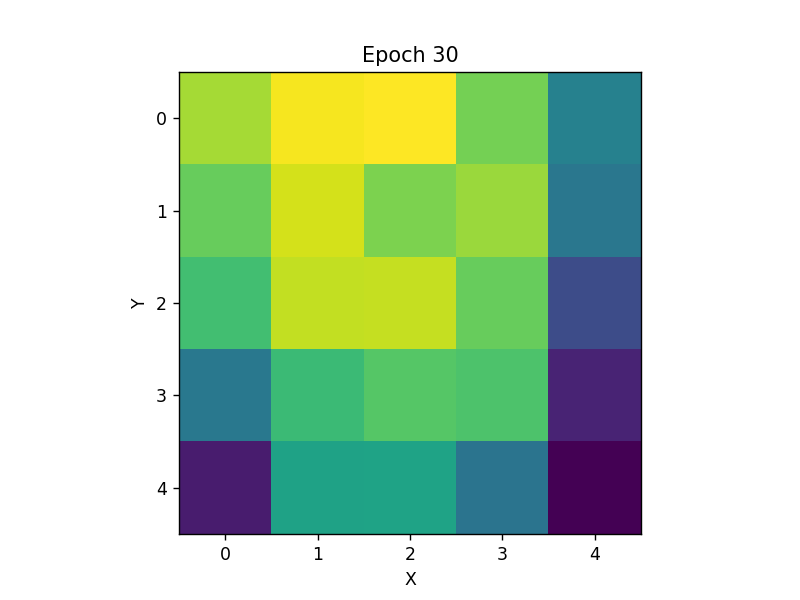

In [38]:
# Function to update the plot for each frame
def update(frame):
    # Clear the previous plot
    ax.cla()

    # Load model
    model_cnn.load_state_dict(torch.load(f"cnn_models/epoch_{frame}.pth"))

    # Plot the data from current frame/epoch
    kernel_weights = model_cnn.state_dict()['conv1.weight'][12]
    # ReLU activation is applied to consider only positive weights
    #normalized_weights = F.relu(kernel_weights) / kernel_weights.max()
    normalized_weights=kernel_weights
    image = normalized_weights.detach().numpy()
    colour = 0 # choose between 0: red, 1: green and 2: blue
    ax.imshow(image[colour,:,:])
    plt.savefig(f'epoch_{frame}.pdf')


    # Set plot title and labels
    ax.set_title(f'Epoch {frame }')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

        
# Number of epochs and batch size used when training
epochs = 30
loss_fn = nn.CrossEntropyLoss()


# Create a figure and axis
fig, ax = plt.subplots()
# Create the animation
animation = FuncAnimation(fig, update, frames=epochs+1, interval=500,repeat=False)

# Display the animation
plt.show()





### Make animation of 1 specific feature map of the first convolutional layer
There are 32 channels in this layer. By changing the variable "channel" one can choose which one to visualise. By changing "input_image" one can choose which image to look at of the 10 images from above.

<IPython.core.display.Javascript object>


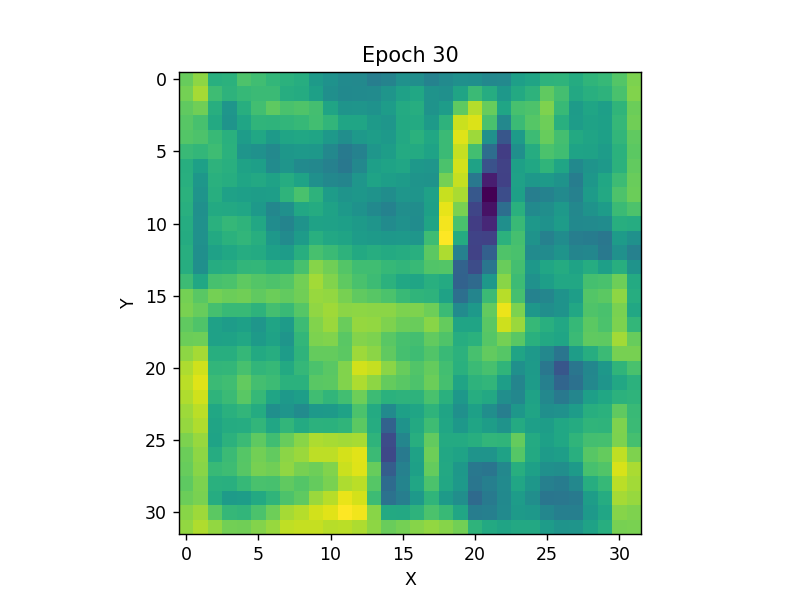

In [55]:
# Create a figure and axis
fig, ax = plt.subplots()

# Function to update the plot for each frame
def update(frame):
    # Clear the previous plot
    ax.cla()

    # Load model
    model_cnn.load_state_dict(torch.load(f"cnn_models/epoch_{frame}.pth"))

    # Plot the data from current frame/epoch
    channel = 12 # choose channel, 12 used for report
    input_image = 6 # chose picture, 6 used for report
    conv1_output = model_cnn.conv1(images[input_image])[channel]
    image = conv1_output.detach().numpy()
    ax.imshow(image)

    # Set plot title and labels
    ax.set_title(f'Epoch {frame }')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

        
# Number of epochs and batch size used when training
epochs = 30
dimensions = (batch_size, 3,32,32)

# Create the animation
animation = FuncAnimation(fig, update, frames=epochs+1, interval=500,repeat=False)

# Display the animation
plt.show()

Do the same for all filters at the same time, doesnt work yet

Animation of first relu layer during training

<IPython.core.display.Javascript object>


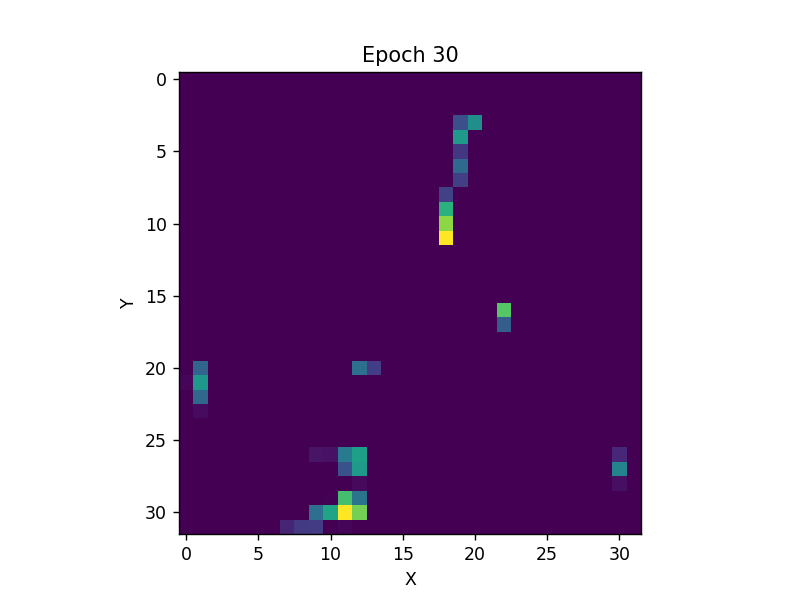

In [57]:

# Create a figure and axis
fig, ax = plt.subplots()

# Function to update the plot for each frame
def update(frame):
    # Clear the previous plot
    ax.cla()

    # Load model
    model.load_state_dict(torch.load(f"cnn_models/epoch_{frame}.pth"))

    # Plot the data from current frame/epoch
    channel = 12 # choose channel, 12 used for report
    input_image = 6 # chose picture, 6 used for report
    relu1_output = model_cnn.relu1(model_cnn.conv1(images[input_image]))[channel]
    image = relu1_output.detach().numpy()
    ax.imshow(image)

    # Set plot title and labels
    ax.set_title(f'Epoch {frame }')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

# Number of epochs and batch size used when training
epochs = 30
dimensions = (batch_size, 3,32,32)
        
# Initialize model
model = CNN(kernel_size = 5, 
            pooling_size = 2, 
            padding_size = 2,
            stride = 1,
            image_dim = dimensions)

# Create the animation
animation = FuncAnimation(fig, update, frames=epochs+1, interval=500,repeat=False)

# Display the animation
plt.show()

In [60]:
Animation of first maxpool layer during training

torch.Size([32, 32])


<IPython.core.display.Javascript object>


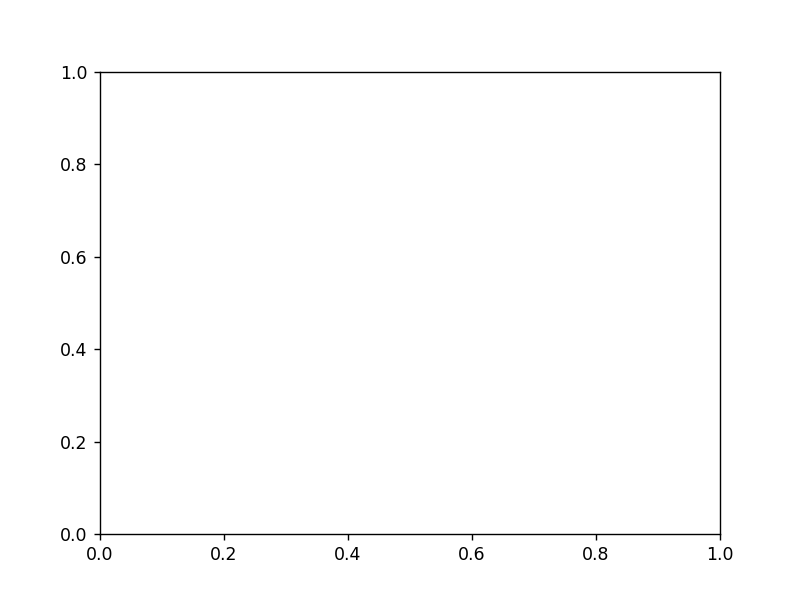

In [53]:
# Create a figure and axis
fig, ax = plt.subplots()

# Function to update the plot for each frame
def update(frame):
    # Clear the previous plot
    ax.cla()

    # Load model
    model_cnn.load_state_dict(torch.load(f"epoch_{frame}.pth"))

    # Plot the data from current frame/epoch
    channel = 12 # choose channel, 12 used for report
    input_image = 6 # chose picture, 6 used for report
    maxpool1_output = model_cnn.maxpool1(model_cnn.relu1(model_cnn.conv1(images[input_image])))[channel]
    image = maxpool1_output.detach().numpy()
    ax.imshow(image)

    # Set plot title and labels
    ax.set_title(f'Epoch {frame }')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
        
# Number of epochs and batch size used when training
epochs = 30
dimensions = (batch_size, 3,32,32)
        
# Initialize model
model = CNN(kernel_size = 5, 
            pooling_size = 2, 
            padding_size = 2,
            stride = 1,
            image_dim = dimensions)

# Create the animation
animation = FuncAnimation(fig, update, frames=epochs+1, interval=500,repeat=False)

# Display the animation
plt.show()

### Plot all layers of the network

<IPython.core.display.Javascript object>


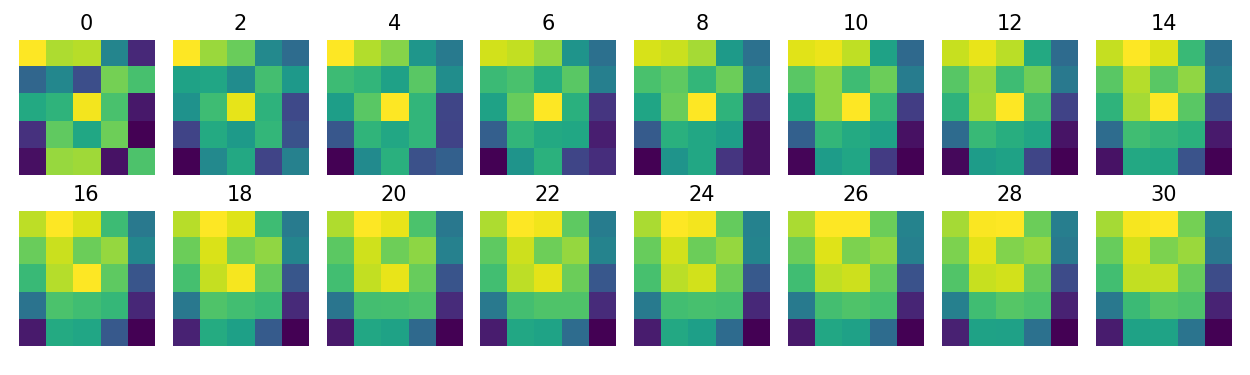

<IPython.core.display.Javascript object>


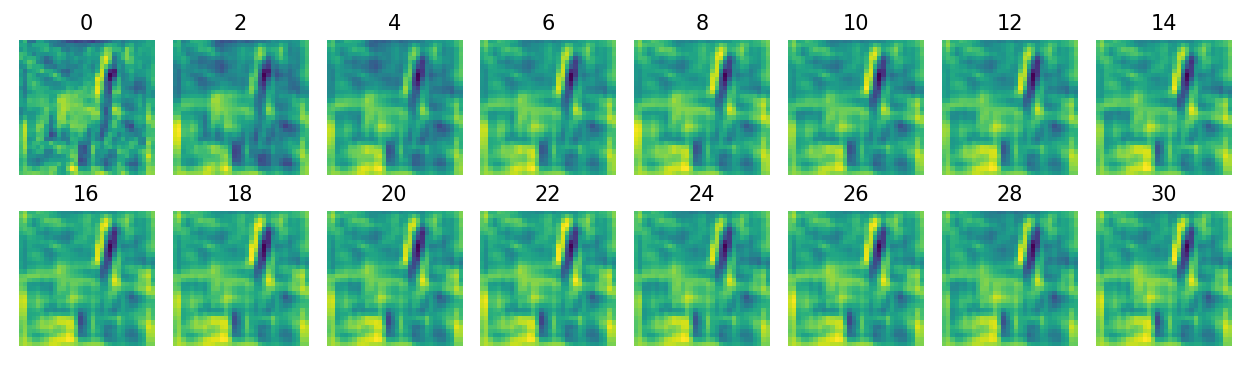

<IPython.core.display.Javascript object>


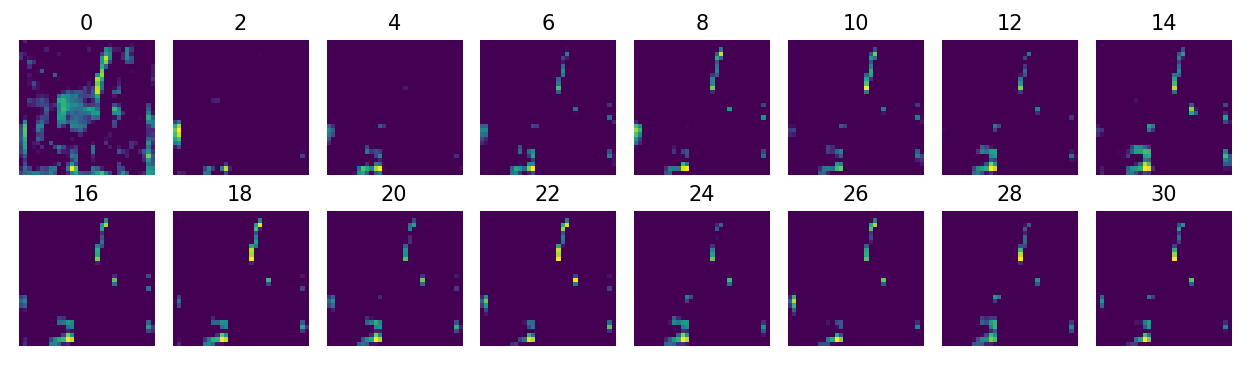

<IPython.core.display.Javascript object>


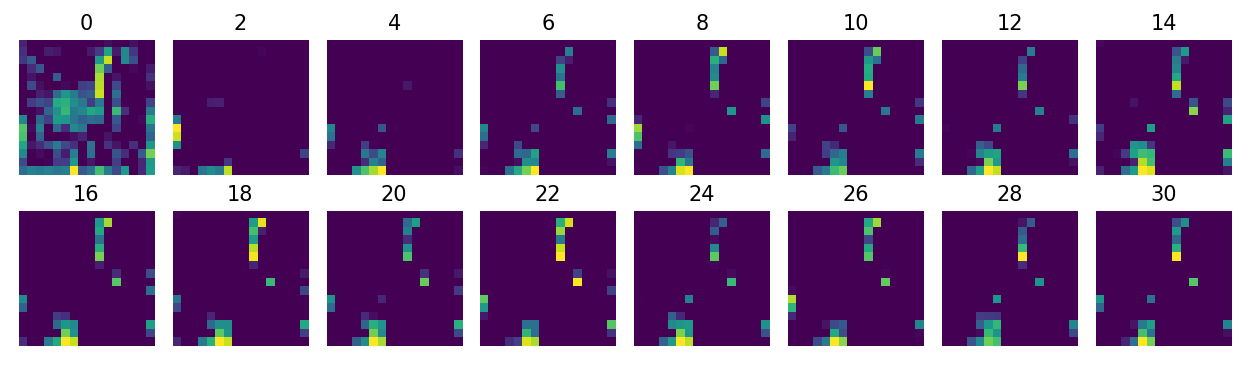

<IPython.core.display.Javascript object>


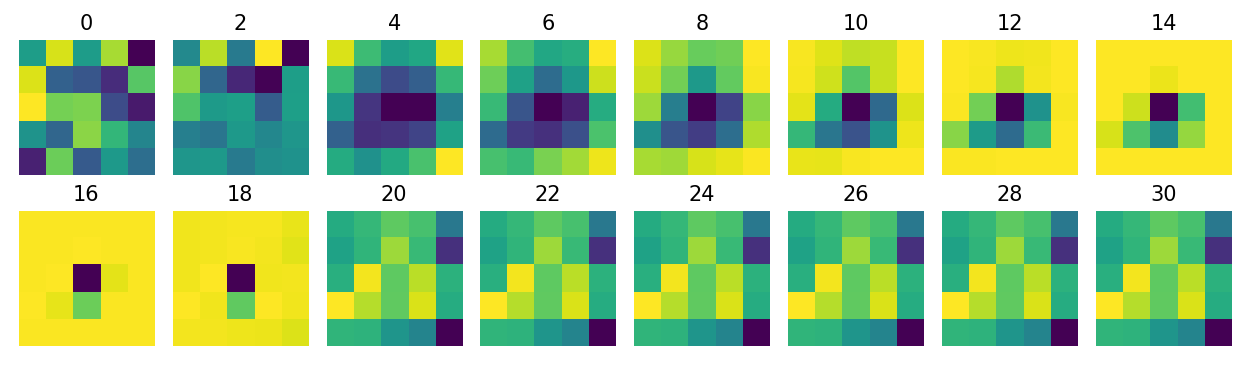

<IPython.core.display.Javascript object>


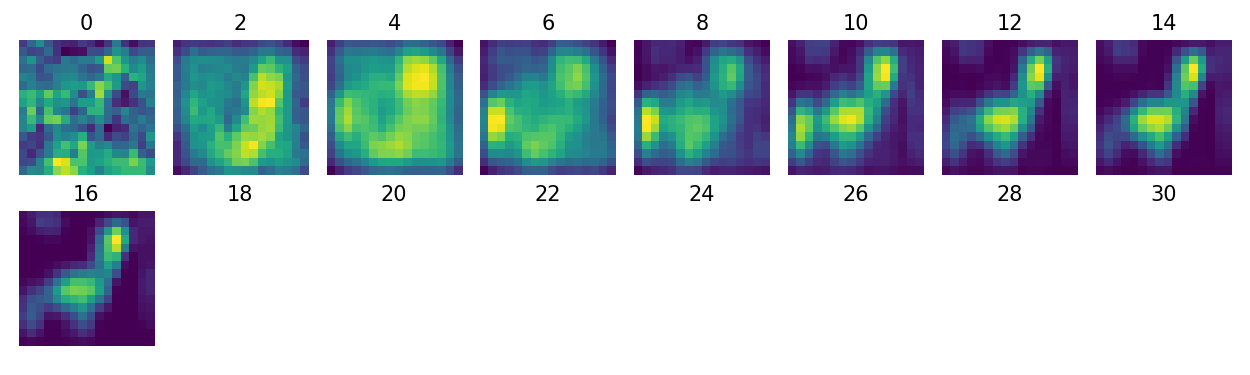

/tmp/ipykernel_119/2869884402.py:74: RuntimeWarning: invalid value encountered in divide
  img_ = img_/img_.max()


<IPython.core.display.Javascript object>


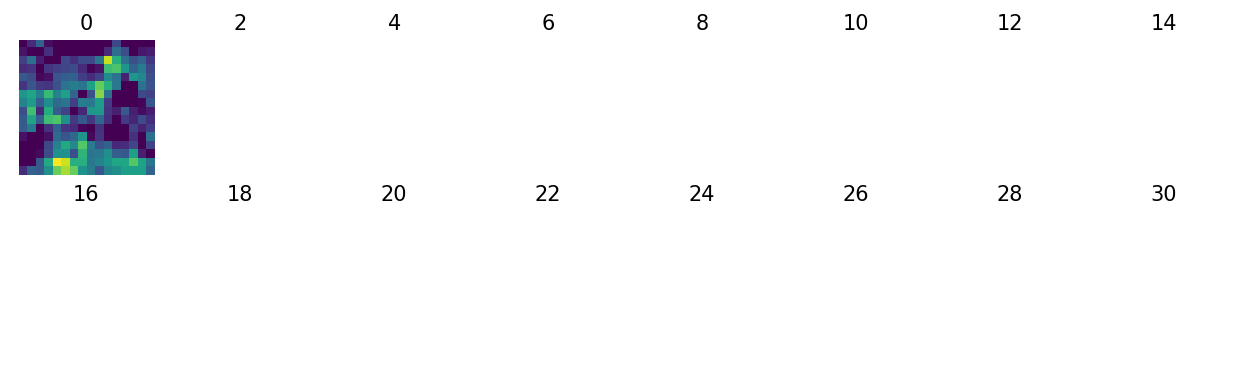

In [61]:
epochs = 30
kernel_1_list = []
kernel_2_list = []
conv_1_list = []
conv_2_list = []
relu_1_list = []
relu_2_list = []
maxpool_1_list = []
maxpool_2_list = []

# choose channel and image
channel = 12 # channel 12 used in report
pic = 6 # picture 6 used in report

for i in range(epochs+1):
    # Load model
    model_cnn.load_state_dict(torch.load(f"cnn_models/epoch_{i}.pth"))

    # get kernel weights
    kernel_weights = model_cnn.state_dict()['conv1.weight'][channel]
    
    #kernel_weights = kernel_weights / kernel_weights.max() # normalized weights
    image = kernel_weights.detach().numpy()
    red_channel = image[0,:,:].copy()
    kernel_1_list.append(red_channel)

    # get first feature map
    conv1_output = model_cnn.conv1(images[pic])[channel]
    #conv1_output = conv1_output /conv1_output.max()
    conv1_output = conv1_output.detach().numpy().copy()
    conv_1_list.append(conv1_output)
    
    # get first relu layer
    relu1_output = model_cnn.relu1(model_cnn.conv1(images[pic]))[channel]
    relu1_output = relu1_output.detach().numpy().copy()
    relu_1_list.append(relu1_output)
    
    # get first maxpool layer
    maxp1_output = model_cnn.maxpool1(model_cnn.relu1(model_cnn.conv1(images[pic])))[channel]
    maxp1_output = maxp1_output.detach().numpy().copy()
    maxpool_1_list.append(maxp1_output)

    # get second kernel weights
    kernel2_weights = model_cnn.state_dict()['conv2.weight'][channel]
    kernel2_weights = kernel2_weights.detach().numpy().copy()
    red2 = kernel2_weights[0,:,:]
    kernel_2_list.append(red2)
    
    # get second feature map
    conv2_output = model_cnn.conv2(model_cnn.maxpool1(model_cnn.relu1(model_cnn.conv1(images[pic]))))[channel]
    conv2_output = conv2_output /conv2_output.max()
    conv2_output = conv2_output.detach().numpy().copy()
    conv_2_list.append(conv2_output)
    
    # get first relu layer
    relu2_output = model_cnn.relu2(model_cnn.conv2(model_cnn.maxpool1(model_cnn.relu1(model_cnn.conv1(images[pic])))))[channel]
    relu2_output = relu2_output.detach().numpy().copy()
    relu_2_list.append(relu2_output)

    
def plot_list(img_list):  
    # Make subplot figure
    num_rows = 2 #number of raws in the subplot
    num_cols = 8 #epochs  #number of columns in the subplot
    # Create the subplot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3)) # Adjust figsize as per your preference
    num_im=0
    # Iterate over the images and plot them in the subplot
    for i in range(num_rows):
        for k in range(num_cols):
            # scale between 0 and 1
            img_ = img_list[num_im] #selected image to plot
            img_ = img_-img_.min()
            img_ = img_/img_.max()
            axes[i, k].imshow(img_, vmin=0, vmax=1 )   #images_list[num_im], vmin=-1, vmax=1)
            axes[i, k].axis('off') # Remove axis labels if desired
            axes[i, k].set_title(f'{num_im}')
            num_im=num_im+2
    # Adjust the spacing and layout of the subplot
    plt.tight_layout()
    plt.show() 
    
# Plot all layers
plot_list(kernel_1_list)
plot_list(conv_1_list)
plot_list(relu_1_list)
plot_list(maxpool_1_list)
plot_list(kernel_2_list)
plot_list(conv_2_list)
plot_list(relu_2_list)

In [58]:
kernel_2_list

[array([[ 0.00320058,  0.027139  ,  0.0029148 ,  0.02270821, -0.03162546],
        [ 0.0277585 , -0.01221127, -0.0149254 , -0.02374223,  0.01464799],
        [ 0.03098713,  0.01796613,  0.01861541, -0.01702322, -0.02700742],
        [ 0.00065784, -0.01091627,  0.0199946 ,  0.00984816, -0.00308486],
        [-0.02578704,  0.0168332 , -0.01384978,  0.00226306, -0.00897708]],
       dtype=float32),
 array([[-0.00238335,  0.00882105, -0.00296848,  0.00768475, -0.01767134],
        [ 0.00888514, -0.00786672, -0.01126249, -0.01539292,  0.00050975],
        [ 0.00507933, -0.00090221, -0.0002432 , -0.01318928, -0.00266972],
        [-0.00702534, -0.01030727, -0.00052229, -0.00415168, -0.00484351],
        [-0.00789227, -0.00149876, -0.01049493, -0.00515745, -0.00615546]],
       dtype=float32),
 array([[-4.7137431e-04,  1.9963924e-03, -8.4346498e-04,  2.6038752e-03,
         -3.2164040e-03],
        [ 1.5757253e-03, -1.2914189e-03, -2.5680924e-03, -3.1798282e-03,
          5.5944074e-05],
    

In [59]:
conv_2_list

[array([[-9.53736305e-02,  1.22541010e-01,  3.18576872e-01,
          3.27842198e-02, -1.35768756e-01, -1.78433329e-01,
         -1.90935403e-01, -8.75852183e-02, -1.57594487e-01,
         -2.67947167e-01, -1.07808471e-01,  2.11420879e-01,
         -1.19483486e-01, -2.62388140e-01, -1.20264247e-01,
         -1.11667193e-01],
        [ 5.43643720e-02, -4.37265150e-02, -2.30864584e-02,
          1.37556896e-01, -1.24578886e-01, -3.10804635e-01,
         -2.81476289e-01, -2.61116892e-01, -1.48046734e-02,
         -1.56437159e-02,  1.21061310e-01,  3.55976969e-01,
          2.36868083e-01, -2.16689017e-02,  6.47183955e-02,
          7.46814534e-02],
        [ 1.89158320e-01,  3.67390037e-01,  8.49922970e-02,
         -3.93793397e-02, -8.35327283e-02,  2.18592122e-01,
          1.37856022e-01,  2.20936686e-01,  2.24695370e-01,
          3.92073095e-01,  9.17441964e-01,  6.26989067e-01,
          3.78422081e-01,  2.42712781e-01,  3.19230616e-01,
          1.60945460e-01],
        [ 1.2787118